In [1]:
import os
import cv2
import glob
import json
import random
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data import build_detection_test_loader
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.evaluation import inference_on_dataset
from detectron2.utils.visualizer import Visualizer

In [2]:
PATH = {
    'train': 'dataset/vegetables/train',
    'val': 'dataset/vegetables/val',
    'test': 'dataset/vegetables/test',
    'coco_train': 'dataset/vegetables/coco/train.json',
    'coco_val': 'dataset/vegetables/coco/val.json',
    'coco_test': 'dataset/vegetables/coco/test.json',
    'faster_rcnn_X_101_32x8d_FPN_3x': 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml',
}

In [3]:
coco_train = COCO(PATH['coco_train'])
coco_val = COCO(PATH['coco_val'])
# coco_test = COCO(PATH['coco_test'])

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


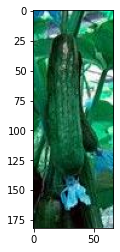

In [4]:
imgIds = coco_train.getImgIds()
imags = coco_train.loadImgs(imgIds)
img = imags[100]
img = cv2.imread(img['coco_url'])
plt.imshow(img)
plt.show()

In [5]:
register_coco_instances('train_dataset', {}, PATH['coco_train'], PATH['train'])
register_coco_instances('val_dataset', {}, PATH['coco_val'], PATH['val'])
# register_coco_instances("test_dataset", {}, PATH['coco_test'], PATH['test'])


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



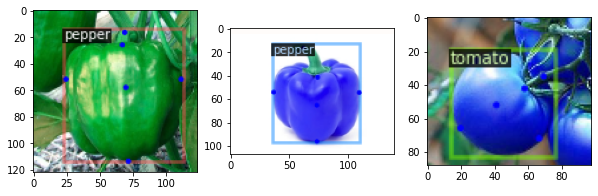

In [6]:
train_dataset_metadata = MetadataCatalog.get("train_dataset")
train_dataset_dicts = DatasetCatalog.get("train_dataset")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
for sample, ax in zip(random.sample(train_dataset_dicts, 3), axs.ravel()):
    img = cv2.imread(sample["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_dataset_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(sample)
    ax.imshow(vis.get_image()[:, :, ::-1])
plt.show()

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(PATH['faster_rcnn_X_101_32x8d_FPN_3x']))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("val_dataset",)

cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(PATH['faster_rcnn_X_101_32x8d_FPN_3x'])  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR

cfg.SOLVER.WARMUP_ITERS = 1000
# 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.MAX_ITER = 1500 
# do not decay learning rate
cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.05

# Faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

cfg.TEST.EVAL_PERIOD = 10

In [8]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/08 03:32:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [07/08 03:32:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 03:32:23 d2.data.datasets.coco]: Loaded 1280 images in COCO format from dataset/vegetables/coco/train.json
[07/08 03:32:23 d2.data.build]: Removed 0 images with no usable annotations. 1280 images left.
[07/08 03:32:23 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  cucumber  | 320          |  eggplant  | 320          |   pepper   | 320          |
|   tomato   | 320          |            |              |            |              |
|   total    | 1280         |            |              |            |              |
[07/08 03:32:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[07/08 03:32:23 d2.engine.train_loop]: Starting training from iteration 0


/home/hujiajun/anaconda3/envs/food-detection/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


WARNING [07/08 03:32:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 03:32:37 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/coco/val.json
[07/08 03:32:37 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  cucumber  | 80           |  eggplant  | 80           |   pepper   | 80           |
|   tomato   | 80           |            |              |            |              |
|   total    | 320          |            |              |            |              |
[07/08 03:32:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/08 03:32:37 d2.data.common]: Serializing 320 elements to

[07/08 03:34:05 d2.evaluation.evaluator]: Inference done 305/320. Dataloading: 0.0007 s/iter. Inference: 0.1186 s/iter. Eval: 0.0004 s/iter. Total: 0.1198 s/iter. ETA=0:00:01
[07/08 03:34:07 d2.evaluation.evaluator]: Total inference time: 0:00:37.582765 (0.119310 s / iter per device, on 1 devices)
[07/08 03:34:07 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:37 (0.118137 s / iter per device, on 1 devices)
[07/08 03:34:07 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:34:07 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:34:07 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
[07/08 03:34:07 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[07/08 03:34:07 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.09 seconds.
[07/08 03:34:07 d2.evaluati

[07/08 03:34:58 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP    | category   | AP    |
|:-----------|:------|:-----------|:------|:-----------|:------|
| cucumber   | 0.001 | eggplant   | 0.010 | pepper     | 0.000 |
| tomato     | 0.000 |            |       |            |       |
[07/08 03:34:58 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:34:58 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:34:58 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:34:58 d2.evaluation.testing]: copypaste: 0.0027,0.0186,0.0002,nan,0.0003,0.0136
WARNING [07/08 03:35:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 03:35:11 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/coco/val.json
[07/08 03:35:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortest

[07/08 03:36:28 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1208 s/iter. Eval: 0.0002 s/iter. Total: 0.1216 s/iter. ETA=0:00:12
[07/08 03:36:33 d2.evaluation.evaluator]: Inference done 262/320. Dataloading: 0.0006 s/iter. Inference: 0.1195 s/iter. Eval: 0.0002 s/iter. Total: 0.1204 s/iter. ETA=0:00:06
[07/08 03:36:38 d2.evaluation.evaluator]: Inference done 307/320. Dataloading: 0.0006 s/iter. Inference: 0.1183 s/iter. Eval: 0.0002 s/iter. Total: 0.1192 s/iter. ETA=0:00:01
[07/08 03:36:40 d2.evaluation.evaluator]: Total inference time: 0:00:37.428833 (0.118822 s / iter per device, on 1 devices)
[07/08 03:36:40 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:37 (0.117865 s / iter per device, on 1 devices)
[07/08 03:36:40 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:36:40 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:36:40 d2.evaluation.c

[07/08 03:37:30 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:37:30 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP    | category   | AP    |
|:-----------|:------|:-----------|:------|:-----------|:------|
| cucumber   | 0.005 | eggplant   | 0.335 | pepper     | 0.000 |
| tomato     | 0.192 |            |       |            |       |
[07/08 03:37:30 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:37:30 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:37:30 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:37:30 d2.evaluation.testing]: copypaste: 0.1332,0.6778,0.0145,nan,0.0005,0.2659
[07/08 03:37:31 d2.utils.events]:  eta: 0:30:55  iter: 59  total_loss: 1.623  loss_cls: 1.243  loss_box_reg: 0.3647  loss_rpn_cls: 0.003268  loss_rpn_loc: 0.01002  time: 1.2242  data_time: 0.0023  lr: 1.4985e-05  max_mem: 6256M
WARNING [07/08 03:37:43 d

[07/08 03:39:00 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1206 s/iter. Eval: 0.0002 s/iter. Total: 0.1215 s/iter. ETA=0:00:12
[07/08 03:39:05 d2.evaluation.evaluator]: Inference done 262/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0005 s/iter. Total: 0.1206 s/iter. ETA=0:00:06
[07/08 03:39:10 d2.evaluation.evaluator]: Inference done 307/320. Dataloading: 0.0006 s/iter. Inference: 0.1183 s/iter. Eval: 0.0004 s/iter. Total: 0.1194 s/iter. ETA=0:00:01
[07/08 03:39:12 d2.evaluation.evaluator]: Total inference time: 0:00:37.490159 (0.119016 s / iter per device, on 1 devices)
[07/08 03:39:12 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:37 (0.117839 s / iter per device, on 1 devices)
[07/08 03:39:12 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:39:12 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:39:12 d2.evaluation.c

[07/08 03:40:03 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:40:03 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP    | category   | AP    |
|:-----------|:------|:-----------|:------|:-----------|:------|
| cucumber   | 0.061 | eggplant   | 2.090 | pepper     | 0.183 |
| tomato     | 0.883 |            |       |            |       |
[07/08 03:40:03 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:40:03 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:40:03 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:40:03 d2.evaluation.testing]: copypaste: 0.8041,3.7025,0.1239,nan,0.0211,1.0800
WARNING [07/08 03:40:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 03:40:15 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/coco/val.json
[07/

[07/08 03:41:31 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1202 s/iter. Eval: 0.0002 s/iter. Total: 0.1211 s/iter. ETA=0:00:12
[07/08 03:41:36 d2.evaluation.evaluator]: Inference done 263/320. Dataloading: 0.0006 s/iter. Inference: 0.1189 s/iter. Eval: 0.0002 s/iter. Total: 0.1198 s/iter. ETA=0:00:06
[07/08 03:41:41 d2.evaluation.evaluator]: Inference done 308/320. Dataloading: 0.0006 s/iter. Inference: 0.1177 s/iter. Eval: 0.0002 s/iter. Total: 0.1186 s/iter. ETA=0:00:01
[07/08 03:41:42 d2.evaluation.evaluator]: Total inference time: 0:00:37.245418 (0.118239 s / iter per device, on 1 devices)
[07/08 03:41:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.117308 s / iter per device, on 1 devices)
[07/08 03:41:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:41:42 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:41:42 d2.evaluation.c

[07/08 03:42:33 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:42:33 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP    | category   | AP    |
|:-----------|:------|:-----------|:------|:-----------|:------|
| cucumber   | 0.109 | eggplant   | 3.515 | pepper     | 0.551 |
| tomato     | 1.512 |            |       |            |       |
[07/08 03:42:33 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:42:33 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:42:33 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:42:33 d2.evaluation.testing]: copypaste: 1.4217,5.8167,0.2887,nan,0.1653,1.7605
[07/08 03:42:33 d2.utils.events]:  eta: 0:28:32  iter: 119  total_loss: 0.7807  loss_cls: 0.376  loss_box_reg: 0.3528  loss_rpn_cls: 0.0006773  loss_rpn_loc: 0.006361  time: 1.2075  data_time: 0.0023  lr: 2.997e-05  max_mem: 6256M
WARNING [07/08 03:42:4

[07/08 03:44:03 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1200 s/iter. Eval: 0.0005 s/iter. Total: 0.1212 s/iter. ETA=0:00:12
[07/08 03:44:08 d2.evaluation.evaluator]: Inference done 263/320. Dataloading: 0.0006 s/iter. Inference: 0.1188 s/iter. Eval: 0.0004 s/iter. Total: 0.1199 s/iter. ETA=0:00:06
[07/08 03:44:13 d2.evaluation.evaluator]: Inference done 308/320. Dataloading: 0.0006 s/iter. Inference: 0.1176 s/iter. Eval: 0.0004 s/iter. Total: 0.1187 s/iter. ETA=0:00:01
[07/08 03:44:14 d2.evaluation.evaluator]: Total inference time: 0:00:37.286069 (0.118368 s / iter per device, on 1 devices)
[07/08 03:44:14 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.117219 s / iter per device, on 1 devices)
[07/08 03:44:14 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:44:14 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:44:15 d2.evaluation.c

[07/08 03:45:06 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:45:06 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP    | category   | AP    |
|:-----------|:------|:-----------|:------|:-----------|:------|
| cucumber   | 0.337 | eggplant   | 6.057 | pepper     | 1.947 |
| tomato     | 2.664 |            |       |            |       |
[07/08 03:45:06 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:45:06 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:45:06 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:45:06 d2.evaluation.testing]: copypaste: 2.7514,10.3280,0.6979,nan,0.4160,2.9524
WARNING [07/08 03:45:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 03:45:18 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/coco/val.json
[07

[07/08 03:46:34 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1202 s/iter. Eval: 0.0002 s/iter. Total: 0.1210 s/iter. ETA=0:00:12
[07/08 03:46:39 d2.evaluation.evaluator]: Inference done 263/320. Dataloading: 0.0006 s/iter. Inference: 0.1189 s/iter. Eval: 0.0002 s/iter. Total: 0.1198 s/iter. ETA=0:00:06
[07/08 03:46:44 d2.evaluation.evaluator]: Inference done 308/320. Dataloading: 0.0006 s/iter. Inference: 0.1177 s/iter. Eval: 0.0002 s/iter. Total: 0.1185 s/iter. ETA=0:00:01
[07/08 03:46:46 d2.evaluation.evaluator]: Total inference time: 0:00:37.231508 (0.118195 s / iter per device, on 1 devices)
[07/08 03:46:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.117267 s / iter per device, on 1 devices)
[07/08 03:46:46 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:46:46 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:46:46 d2.evaluation.c

[07/08 03:47:36 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:47:36 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP    | category   | AP    |
|:-----------|:------|:-----------|:------|:-----------|:------|
| cucumber   | 0.994 | eggplant   | 8.456 | pepper     | 4.312 |
| tomato     | 3.906 |            |       |            |       |
[07/08 03:47:36 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:47:36 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:47:36 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:47:36 d2.evaluation.testing]: copypaste: 4.4172,16.1285,1.2721,nan,1.2431,4.5111
[07/08 03:47:36 d2.utils.events]:  eta: 0:27:56  iter: 179  total_loss: 0.692  loss_cls: 0.3107  loss_box_reg: 0.3735  loss_rpn_cls: 0.000492  loss_rpn_loc: 0.005284  time: 1.2110  data_time: 0.0024  lr: 4.4955e-05  max_mem: 6256M
WARNING [07/08 03:47:

[07/08 03:49:03 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1199 s/iter. Eval: 0.0005 s/iter. Total: 0.1211 s/iter. ETA=0:00:12
[07/08 03:49:08 d2.evaluation.evaluator]: Inference done 263/320. Dataloading: 0.0006 s/iter. Inference: 0.1187 s/iter. Eval: 0.0004 s/iter. Total: 0.1198 s/iter. ETA=0:00:06
[07/08 03:49:13 d2.evaluation.evaluator]: Inference done 308/320. Dataloading: 0.0006 s/iter. Inference: 0.1174 s/iter. Eval: 0.0004 s/iter. Total: 0.1185 s/iter. ETA=0:00:01
[07/08 03:49:14 d2.evaluation.evaluator]: Total inference time: 0:00:37.228156 (0.118185 s / iter per device, on 1 devices)
[07/08 03:49:14 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.117043 s / iter per device, on 1 devices)
[07/08 03:49:14 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:49:14 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:49:14 d2.evaluation.c

[07/08 03:50:05 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:50:05 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP     | category   | AP    |
|:-----------|:------|:-----------|:-------|:-----------|:------|
| cucumber   | 1.367 | eggplant   | 11.731 | pepper     | 8.801 |
| tomato     | 5.172 |            |        |            |       |
[07/08 03:50:05 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:50:05 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:50:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:50:05 d2.evaluation.testing]: copypaste: 6.7676,22.7101,2.5281,nan,6.6615,6.8086
WARNING [07/08 03:50:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 03:50:16 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/coco/val.json

[07/08 03:51:33 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1198 s/iter. Eval: 0.0002 s/iter. Total: 0.1206 s/iter. ETA=0:00:12
[07/08 03:51:38 d2.evaluation.evaluator]: Inference done 263/320. Dataloading: 0.0006 s/iter. Inference: 0.1186 s/iter. Eval: 0.0002 s/iter. Total: 0.1194 s/iter. ETA=0:00:06
[07/08 03:51:43 d2.evaluation.evaluator]: Inference done 309/320. Dataloading: 0.0006 s/iter. Inference: 0.1173 s/iter. Eval: 0.0002 s/iter. Total: 0.1182 s/iter. ETA=0:00:01
[07/08 03:51:44 d2.evaluation.evaluator]: Total inference time: 0:00:37.122484 (0.117849 s / iter per device, on 1 devices)
[07/08 03:51:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116948 s / iter per device, on 1 devices)
[07/08 03:51:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:51:44 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:51:44 d2.evaluation.c

[07/08 03:52:37 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:52:37 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| cucumber   | 1.968 | eggplant   | 11.327 | pepper     | 12.598 |
| tomato     | 7.184 |            |        |            |        |
[07/08 03:52:37 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:52:37 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:52:37 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:52:37 d2.evaluation.testing]: copypaste: 8.2692,27.4700,2.1069,nan,5.8374,8.3351
[07/08 03:52:37 d2.utils.events]:  eta: 0:26:36  iter: 239  total_loss: 0.627  loss_cls: 0.241  loss_box_reg: 0.3717  loss_rpn_cls: 0.0007948  loss_rpn_loc: 0.007195  time: 1.2038  data_time: 0.0024  lr: 5.994e-05  max_mem: 6256M
WARNING [07/08

[07/08 03:54:04 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1197 s/iter. Eval: 0.0002 s/iter. Total: 0.1205 s/iter. ETA=0:00:12
[07/08 03:54:09 d2.evaluation.evaluator]: Inference done 263/320. Dataloading: 0.0006 s/iter. Inference: 0.1184 s/iter. Eval: 0.0002 s/iter. Total: 0.1193 s/iter. ETA=0:00:06
[07/08 03:54:14 d2.evaluation.evaluator]: Inference done 308/320. Dataloading: 0.0006 s/iter. Inference: 0.1173 s/iter. Eval: 0.0002 s/iter. Total: 0.1181 s/iter. ETA=0:00:01
[07/08 03:54:16 d2.evaluation.evaluator]: Total inference time: 0:00:37.099865 (0.117777 s / iter per device, on 1 devices)
[07/08 03:54:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116877 s / iter per device, on 1 devices)
[07/08 03:54:16 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/08 03:54:16 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[07/08 03:54:16 d2.evaluation.c

[07/08 03:55:05 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:55:05 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| cucumber   | 2.952 | eggplant   | 13.430 | pepper     | 17.361 |
| tomato     | 9.257 |            |        |            |        |
[07/08 03:55:05 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:55:05 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:55:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:55:05 d2.evaluation.testing]: copypaste: 10.7503,33.7269,3.4105,nan,6.8139,10.8079
WARNING [07/08 03:55:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 03:55:17 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/coco/va

[07/08 03:56:29 d2.evaluation.evaluator]: Inference done 175/320. Dataloading: 0.0006 s/iter. Inference: 0.1211 s/iter. Eval: 0.0002 s/iter. Total: 0.1220 s/iter. ETA=0:00:17
[07/08 03:56:34 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0006 s/iter. Inference: 0.1201 s/iter. Eval: 0.0002 s/iter. Total: 0.1209 s/iter. ETA=0:00:12
[07/08 03:56:39 d2.evaluation.evaluator]: Inference done 263/320. Dataloading: 0.0006 s/iter. Inference: 0.1187 s/iter. Eval: 0.0002 s/iter. Total: 0.1196 s/iter. ETA=0:00:06
[07/08 03:56:44 d2.evaluation.evaluator]: Inference done 309/320. Dataloading: 0.0006 s/iter. Inference: 0.1175 s/iter. Eval: 0.0002 s/iter. Total: 0.1183 s/iter. ETA=0:00:01
[07/08 03:56:45 d2.evaluation.evaluator]: Total inference time: 0:00:37.178816 (0.118028 s / iter per device, on 1 devices)
[07/08 03:56:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.117117 s / iter per device, on 1 devices)
[07/08 03:56:45 d2.evaluation.coco_evaluation]

[07/08 03:57:34 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 03:57:34 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 4.223  | eggplant   | 16.637 | pepper     | 21.430 |
| tomato     | 12.035 |            |        |            |        |
[07/08 03:57:34 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 03:57:34 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 03:57:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 03:57:34 d2.evaluation.testing]: copypaste: 13.5813,40.9290,3.6072,nan,11.5873,13.6416
[07/08 03:57:34 d2.utils.events]:  eta: 0:25:12  iter: 299  total_loss: 0.7487  loss_cls: 0.2771  loss_box_reg: 0.4614  loss_rpn_cls: 0.0002234  loss_rpn_loc: 0.00466  time: 1.1902  data_time: 0.0024  lr: 7.4925e-05  max_mem: 6256M
WARNI

[07/08 03:58:56 d2.evaluation.evaluator]: Inference done 175/320. Dataloading: 0.0007 s/iter. Inference: 0.1207 s/iter. Eval: 0.0002 s/iter. Total: 0.1216 s/iter. ETA=0:00:17
[07/08 03:59:01 d2.evaluation.evaluator]: Inference done 218/320. Dataloading: 0.0007 s/iter. Inference: 0.1197 s/iter. Eval: 0.0002 s/iter. Total: 0.1206 s/iter. ETA=0:00:12
[07/08 03:59:06 d2.evaluation.evaluator]: Inference done 263/320. Dataloading: 0.0007 s/iter. Inference: 0.1185 s/iter. Eval: 0.0002 s/iter. Total: 0.1194 s/iter. ETA=0:00:06
[07/08 03:59:11 d2.evaluation.evaluator]: Inference done 309/320. Dataloading: 0.0007 s/iter. Inference: 0.1172 s/iter. Eval: 0.0002 s/iter. Total: 0.1181 s/iter. ETA=0:00:01
[07/08 03:59:12 d2.evaluation.evaluator]: Total inference time: 0:00:37.107725 (0.117802 s / iter per device, on 1 devices)
[07/08 03:59:12 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116859 s / iter per device, on 1 devices)
[07/08 03:59:13 d2.evaluation.coco_evaluation]

[07/08 04:00:03 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:00:03 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 5.684  | eggplant   | 19.540 | pepper     | 23.083 |
| tomato     | 13.720 |            |        |            |        |
[07/08 04:00:03 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:00:03 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:00:03 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:00:03 d2.evaluation.testing]: copypaste: 15.5066,46.1664,5.7958,nan,12.9828,15.6042
WARNING [07/08 04:00:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:00:16 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/co

[07/08 04:01:27 d2.evaluation.evaluator]: Inference done 176/320. Dataloading: 0.0007 s/iter. Inference: 0.1205 s/iter. Eval: 0.0002 s/iter. Total: 0.1213 s/iter. ETA=0:00:17
[07/08 04:01:32 d2.evaluation.evaluator]: Inference done 219/320. Dataloading: 0.0007 s/iter. Inference: 0.1195 s/iter. Eval: 0.0002 s/iter. Total: 0.1204 s/iter. ETA=0:00:12
[07/08 04:01:37 d2.evaluation.evaluator]: Inference done 264/320. Dataloading: 0.0006 s/iter. Inference: 0.1183 s/iter. Eval: 0.0002 s/iter. Total: 0.1191 s/iter. ETA=0:00:06
[07/08 04:01:42 d2.evaluation.evaluator]: Inference done 309/320. Dataloading: 0.0006 s/iter. Inference: 0.1171 s/iter. Eval: 0.0002 s/iter. Total: 0.1179 s/iter. ETA=0:00:01
[07/08 04:01:43 d2.evaluation.evaluator]: Total inference time: 0:00:37.045284 (0.117604 s / iter per device, on 1 devices)
[07/08 04:01:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116703 s / iter per device, on 1 devices)
[07/08 04:01:43 d2.evaluation.coco_evaluation]

[07/08 04:02:35 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:02:35 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 8.808  | eggplant   | 21.436 | pepper     | 23.110 |
| tomato     | 21.509 |            |        |            |        |
[07/08 04:02:35 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:02:35 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:02:35 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:02:35 d2.evaluation.testing]: copypaste: 18.7160,55.0291,4.4679,nan,14.6356,18.8106
[07/08 04:02:35 d2.utils.events]:  eta: 0:23:58  iter: 359  total_loss: 0.7184  loss_cls: 0.2556  loss_box_reg: 0.453  loss_rpn_cls: 0.0002112  loss_rpn_loc: 0.006423  time: 1.1950  data_time: 0.0024  lr: 8.991e-05  max_mem: 6256M
WARNIN

[07/08 04:03:58 d2.evaluation.evaluator]: Inference done 176/320. Dataloading: 0.0006 s/iter. Inference: 0.1203 s/iter. Eval: 0.0002 s/iter. Total: 0.1211 s/iter. ETA=0:00:17
[07/08 04:04:03 d2.evaluation.evaluator]: Inference done 219/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0002 s/iter. Total: 0.1202 s/iter. ETA=0:00:12
[07/08 04:04:08 d2.evaluation.evaluator]: Inference done 264/320. Dataloading: 0.0006 s/iter. Inference: 0.1182 s/iter. Eval: 0.0002 s/iter. Total: 0.1190 s/iter. ETA=0:00:06
[07/08 04:04:13 d2.evaluation.evaluator]: Inference done 309/320. Dataloading: 0.0006 s/iter. Inference: 0.1170 s/iter. Eval: 0.0002 s/iter. Total: 0.1179 s/iter. ETA=0:00:01
[07/08 04:04:15 d2.evaluation.evaluator]: Total inference time: 0:00:37.036274 (0.117575 s / iter per device, on 1 devices)
[07/08 04:04:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116660 s / iter per device, on 1 devices)
[07/08 04:04:15 d2.evaluation.coco_evaluation]

[07/08 04:05:05 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:05:05 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 11.368 | eggplant   | 25.863 | pepper     | 26.040 |
| tomato     | 23.812 |            |        |            |        |
[07/08 04:05:05 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:05:05 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:05:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:05:05 d2.evaluation.testing]: copypaste: 21.7707,58.2237,8.0499,nan,14.0582,21.9142
WARNING [07/08 04:05:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:05:17 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/co

[07/08 04:06:29 d2.evaluation.evaluator]: Inference done 176/320. Dataloading: 0.0006 s/iter. Inference: 0.1204 s/iter. Eval: 0.0002 s/iter. Total: 0.1213 s/iter. ETA=0:00:17
[07/08 04:06:34 d2.evaluation.evaluator]: Inference done 219/320. Dataloading: 0.0006 s/iter. Inference: 0.1195 s/iter. Eval: 0.0002 s/iter. Total: 0.1203 s/iter. ETA=0:00:12
[07/08 04:06:39 d2.evaluation.evaluator]: Inference done 264/320. Dataloading: 0.0006 s/iter. Inference: 0.1182 s/iter. Eval: 0.0002 s/iter. Total: 0.1190 s/iter. ETA=0:00:06
[07/08 04:06:45 d2.evaluation.evaluator]: Inference done 310/320. Dataloading: 0.0006 s/iter. Inference: 0.1170 s/iter. Eval: 0.0002 s/iter. Total: 0.1178 s/iter. ETA=0:00:01
[07/08 04:06:46 d2.evaluation.evaluator]: Total inference time: 0:00:37.016758 (0.117514 s / iter per device, on 1 devices)
[07/08 04:06:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116621 s / iter per device, on 1 devices)
[07/08 04:06:46 d2.evaluation.coco_evaluation]

[07/08 04:07:36 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:07:36 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 11.291 | eggplant   | 24.712 | pepper     | 28.650 |
| tomato     | 28.168 |            |        |            |        |
[07/08 04:07:36 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:07:36 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:07:36 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:07:36 d2.evaluation.testing]: copypaste: 23.2052,61.9284,6.9075,nan,11.0526,23.5172
[07/08 04:07:36 d2.utils.events]:  eta: 0:22:42  iter: 419  total_loss: 0.6998  loss_cls: 0.2278  loss_box_reg: 0.4425  loss_rpn_cls: 0.0004267  loss_rpn_loc: 0.008549  time: 1.1960  data_time: 0.0023  lr: 0.0001049  max_mem: 6256M
WARNI

[07/08 04:08:58 d2.evaluation.evaluator]: Inference done 176/320. Dataloading: 0.0007 s/iter. Inference: 0.1204 s/iter. Eval: 0.0002 s/iter. Total: 0.1212 s/iter. ETA=0:00:17
[07/08 04:09:03 d2.evaluation.evaluator]: Inference done 219/320. Dataloading: 0.0007 s/iter. Inference: 0.1194 s/iter. Eval: 0.0002 s/iter. Total: 0.1203 s/iter. ETA=0:00:12
[07/08 04:09:09 d2.evaluation.evaluator]: Inference done 264/320. Dataloading: 0.0006 s/iter. Inference: 0.1182 s/iter. Eval: 0.0002 s/iter. Total: 0.1190 s/iter. ETA=0:00:06
[07/08 04:09:14 d2.evaluation.evaluator]: Inference done 310/320. Dataloading: 0.0006 s/iter. Inference: 0.1169 s/iter. Eval: 0.0002 s/iter. Total: 0.1177 s/iter. ETA=0:00:01
[07/08 04:09:15 d2.evaluation.evaluator]: Total inference time: 0:00:37.000993 (0.117463 s / iter per device, on 1 devices)
[07/08 04:09:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116545 s / iter per device, on 1 devices)
[07/08 04:09:15 d2.evaluation.coco_evaluation]

[07/08 04:10:05 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:10:05 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 15.274 | eggplant   | 28.285 | pepper     | 29.221 |
| tomato     | 26.941 |            |        |            |        |
[07/08 04:10:05 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:10:05 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:10:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:10:05 d2.evaluation.testing]: copypaste: 24.9302,64.1746,11.0115,nan,18.0936,25.3029
WARNING [07/08 04:10:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:10:16 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:11:28 d2.evaluation.evaluator]: Inference done 176/320. Dataloading: 0.0006 s/iter. Inference: 0.1201 s/iter. Eval: 0.0006 s/iter. Total: 0.1213 s/iter. ETA=0:00:17
[07/08 04:11:34 d2.evaluation.evaluator]: Inference done 220/320. Dataloading: 0.0006 s/iter. Inference: 0.1191 s/iter. Eval: 0.0005 s/iter. Total: 0.1202 s/iter. ETA=0:00:12
[07/08 04:11:39 d2.evaluation.evaluator]: Inference done 265/320. Dataloading: 0.0006 s/iter. Inference: 0.1179 s/iter. Eval: 0.0004 s/iter. Total: 0.1190 s/iter. ETA=0:00:06
[07/08 04:11:44 d2.evaluation.evaluator]: Inference done 311/320. Dataloading: 0.0006 s/iter. Inference: 0.1167 s/iter. Eval: 0.0004 s/iter. Total: 0.1177 s/iter. ETA=0:00:01
[07/08 04:11:45 d2.evaluation.evaluator]: Total inference time: 0:00:37.014591 (0.117507 s / iter per device, on 1 devices)
[07/08 04:11:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116368 s / iter per device, on 1 devices)
[07/08 04:11:45 d2.evaluation.coco_evaluation]

[07/08 04:12:34 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:12:34 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 15.032 | eggplant   | 27.802 | pepper     | 31.197 |
| tomato     | 33.460 |            |        |            |        |
[07/08 04:12:34 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:12:34 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:12:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:12:34 d2.evaluation.testing]: copypaste: 26.8729,66.9742,11.1930,nan,19.4451,27.4994
[07/08 04:12:34 d2.utils.events]:  eta: 0:21:01  iter: 479  total_loss: 0.7074  loss_cls: 0.2276  loss_box_reg: 0.4959  loss_rpn_cls: 1.841e-05  loss_rpn_loc: 0.004563  time: 1.1935  data_time: 0.0025  lr: 0.00011988  max_mem: 6256M
WAR

[07/08 04:13:57 d2.evaluation.evaluator]: Inference done 177/320. Dataloading: 0.0006 s/iter. Inference: 0.1202 s/iter. Eval: 0.0001 s/iter. Total: 0.1211 s/iter. ETA=0:00:17
[07/08 04:14:02 d2.evaluation.evaluator]: Inference done 221/320. Dataloading: 0.0007 s/iter. Inference: 0.1193 s/iter. Eval: 0.0001 s/iter. Total: 0.1201 s/iter. ETA=0:00:11
[07/08 04:14:07 d2.evaluation.evaluator]: Inference done 266/320. Dataloading: 0.0007 s/iter. Inference: 0.1179 s/iter. Eval: 0.0001 s/iter. Total: 0.1187 s/iter. ETA=0:00:06
[07/08 04:14:12 d2.evaluation.evaluator]: Inference done 312/320. Dataloading: 0.0007 s/iter. Inference: 0.1166 s/iter. Eval: 0.0001 s/iter. Total: 0.1175 s/iter. ETA=0:00:00
[07/08 04:14:13 d2.evaluation.evaluator]: Total inference time: 0:00:36.936263 (0.117258 s / iter per device, on 1 devices)
[07/08 04:14:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.116346 s / iter per device, on 1 devices)
[07/08 04:14:13 d2.evaluation.coco_evaluation]

[07/08 04:15:03 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:15:03 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 29.175 | eggplant   | 32.425 | pepper     | 27.176 |
| tomato     | 46.412 |            |        |            |        |
[07/08 04:15:03 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:15:03 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:15:03 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:15:03 d2.evaluation.testing]: copypaste: 33.7971,71.9046,22.0461,nan,24.1740,34.3399
WARNING [07/08 04:15:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:15:16 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:16:25 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1196 s/iter. Eval: 0.0001 s/iter. Total: 0.1204 s/iter. ETA=0:00:17
[07/08 04:16:30 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1187 s/iter. Eval: 0.0001 s/iter. Total: 0.1195 s/iter. ETA=0:00:11
[07/08 04:16:35 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1173 s/iter. Eval: 0.0001 s/iter. Total: 0.1181 s/iter. ETA=0:00:06
[07/08 04:16:40 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1169 s/iter. ETA=0:00:00
[07/08 04:16:41 d2.evaluation.evaluator]: Total inference time: 0:00:36.752766 (0.116675 s / iter per device, on 1 devices)
[07/08 04:16:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115799 s / iter per device, on 1 devices)
[07/08 04:16:41 d2.evaluation.coco_evaluation]

[07/08 04:17:30 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:17:30 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 37.819 | eggplant   | 31.321 | pepper     | 39.616 |
| tomato     | 49.893 |            |        |            |        |
[07/08 04:17:30 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:17:30 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:17:30 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:17:30 d2.evaluation.testing]: copypaste: 39.6621,75.8551,31.4012,nan,21.9967,41.0676
[07/08 04:17:30 d2.utils.events]:  eta: 0:19:33  iter: 539  total_loss: 0.7065  loss_cls: 0.2015  loss_box_reg: 0.4802  loss_rpn_cls: 4.208e-06  loss_rpn_loc: 0.005314  time: 1.1882  data_time: 0.0024  lr: 0.00013487  max_mem: 6256M
WAR

[07/08 04:18:54 d2.evaluation.evaluator]: Inference done 180/320. Dataloading: 0.0006 s/iter. Inference: 0.1191 s/iter. Eval: 0.0001 s/iter. Total: 0.1199 s/iter. ETA=0:00:16
[07/08 04:18:59 d2.evaluation.evaluator]: Inference done 224/320. Dataloading: 0.0006 s/iter. Inference: 0.1181 s/iter. Eval: 0.0001 s/iter. Total: 0.1189 s/iter. ETA=0:00:11
[07/08 04:19:04 d2.evaluation.evaluator]: Inference done 270/320. Dataloading: 0.0006 s/iter. Inference: 0.1167 s/iter. Eval: 0.0001 s/iter. Total: 0.1175 s/iter. ETA=0:00:05
[07/08 04:19:09 d2.evaluation.evaluator]: Inference done 316/320. Dataloading: 0.0006 s/iter. Inference: 0.1154 s/iter. Eval: 0.0001 s/iter. Total: 0.1162 s/iter. ETA=0:00:00
[07/08 04:19:10 d2.evaluation.evaluator]: Total inference time: 0:00:36.608053 (0.116216 s / iter per device, on 1 devices)
[07/08 04:19:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115342 s / iter per device, on 1 devices)
[07/08 04:19:10 d2.evaluation.coco_evaluation]

[07/08 04:19:58 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:19:58 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 42.527 | eggplant   | 47.056 | pepper     | 61.207 |
| tomato     | 48.273 |            |        |            |        |
[07/08 04:19:58 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:19:58 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:19:58 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:19:58 d2.evaluation.testing]: copypaste: 49.7656,85.0456,51.0313,nan,28.4554,50.6928
WARNING [07/08 04:20:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:20:10 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:21:20 d2.evaluation.evaluator]: Inference done 179/320. Dataloading: 0.0006 s/iter. Inference: 0.1190 s/iter. Eval: 0.0001 s/iter. Total: 0.1198 s/iter. ETA=0:00:16
[07/08 04:21:25 d2.evaluation.evaluator]: Inference done 223/320. Dataloading: 0.0006 s/iter. Inference: 0.1182 s/iter. Eval: 0.0001 s/iter. Total: 0.1190 s/iter. ETA=0:00:11
[07/08 04:21:30 d2.evaluation.evaluator]: Inference done 268/320. Dataloading: 0.0006 s/iter. Inference: 0.1169 s/iter. Eval: 0.0001 s/iter. Total: 0.1177 s/iter. ETA=0:00:06
[07/08 04:21:36 d2.evaluation.evaluator]: Inference done 314/320. Dataloading: 0.0007 s/iter. Inference: 0.1157 s/iter. Eval: 0.0001 s/iter. Total: 0.1165 s/iter. ETA=0:00:00
[07/08 04:21:36 d2.evaluation.evaluator]: Total inference time: 0:00:36.655658 (0.116367 s / iter per device, on 1 devices)
[07/08 04:21:36 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115477 s / iter per device, on 1 devices)
[07/08 04:21:36 d2.evaluation.coco_evaluation]

[07/08 04:22:25 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:22:25 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 54.164 | eggplant   | 47.478 | pepper     | 58.743 |
| tomato     | 48.879 |            |        |            |        |
[07/08 04:22:25 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:22:25 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:22:25 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:22:25 d2.evaluation.testing]: copypaste: 52.3160,88.7792,58.3823,nan,32.6716,53.2730
[07/08 04:22:25 d2.utils.events]:  eta: 0:18:20  iter: 599  total_loss: 0.5228  loss_cls: 0.1212  loss_box_reg: 0.3886  loss_rpn_cls: 3.755e-06  loss_rpn_loc: 0.007281  time: 1.1870  data_time: 0.0023  lr: 0.00014985  max_mem: 6256M
WAR

[07/08 04:23:47 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0001 s/iter. Total: 0.1202 s/iter. ETA=0:00:17
[07/08 04:23:52 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 04:23:57 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1171 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 04:24:03 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1159 s/iter. Eval: 0.0001 s/iter. Total: 0.1167 s/iter. ETA=0:00:00
[07/08 04:24:03 d2.evaluation.evaluator]: Total inference time: 0:00:36.705548 (0.116526 s / iter per device, on 1 devices)
[07/08 04:24:03 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115635 s / iter per device, on 1 devices)
[07/08 04:24:03 d2.evaluation.coco_evaluation]

[07/08 04:24:52 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:24:52 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 47.055 | eggplant   | 51.572 | pepper     | 58.530 |
| tomato     | 55.891 |            |        |            |        |
[07/08 04:24:52 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:24:52 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:24:52 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:24:52 d2.evaluation.testing]: copypaste: 53.2620,89.8804,61.2580,nan,53.3734,54.5395
WARNING [07/08 04:25:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:25:02 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:26:13 d2.evaluation.evaluator]: Inference done 179/320. Dataloading: 0.0006 s/iter. Inference: 0.1192 s/iter. Eval: 0.0001 s/iter. Total: 0.1200 s/iter. ETA=0:00:16
[07/08 04:26:18 d2.evaluation.evaluator]: Inference done 223/320. Dataloading: 0.0007 s/iter. Inference: 0.1183 s/iter. Eval: 0.0001 s/iter. Total: 0.1192 s/iter. ETA=0:00:11
[07/08 04:26:23 d2.evaluation.evaluator]: Inference done 268/320. Dataloading: 0.0007 s/iter. Inference: 0.1170 s/iter. Eval: 0.0001 s/iter. Total: 0.1178 s/iter. ETA=0:00:06
[07/08 04:26:28 d2.evaluation.evaluator]: Inference done 314/320. Dataloading: 0.0007 s/iter. Inference: 0.1158 s/iter. Eval: 0.0001 s/iter. Total: 0.1166 s/iter. ETA=0:00:00
[07/08 04:26:29 d2.evaluation.evaluator]: Total inference time: 0:00:36.691140 (0.116480 s / iter per device, on 1 devices)
[07/08 04:26:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115604 s / iter per device, on 1 devices)
[07/08 04:26:29 d2.evaluation.coco_evaluation]

[07/08 04:27:17 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:27:17 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 60.954 | eggplant   | 55.572 | pepper     | 69.079 |
| tomato     | 58.270 |            |        |            |        |
[07/08 04:27:17 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:27:17 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:27:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:27:17 d2.evaluation.testing]: copypaste: 60.9689,88.9711,74.4289,nan,32.1120,63.6494
[07/08 04:27:17 d2.utils.events]:  eta: 0:17:01  iter: 659  total_loss: 0.4231  loss_cls: 0.09419  loss_box_reg: 0.2978  loss_rpn_cls: 1.206e-06  loss_rpn_loc: 0.00555  time: 1.1808  data_time: 0.0024  lr: 0.00016484  max_mem: 6256M
WAR

[07/08 04:28:40 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1194 s/iter. Eval: 0.0001 s/iter. Total: 0.1203 s/iter. ETA=0:00:17
[07/08 04:28:45 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 04:28:50 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1171 s/iter. Eval: 0.0001 s/iter. Total: 0.1179 s/iter. ETA=0:00:06
[07/08 04:28:55 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1159 s/iter. Eval: 0.0001 s/iter. Total: 0.1167 s/iter. ETA=0:00:00
[07/08 04:28:56 d2.evaluation.evaluator]: Total inference time: 0:00:36.702256 (0.116515 s / iter per device, on 1 devices)
[07/08 04:28:56 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115646 s / iter per device, on 1 devices)
[07/08 04:28:56 d2.evaluation.coco_evaluation]

[07/08 04:29:44 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:29:44 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 60.269 | eggplant   | 58.180 | pepper     | 67.615 |
| tomato     | 60.937 |            |        |            |        |
[07/08 04:29:44 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:29:44 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:29:44 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:29:44 d2.evaluation.testing]: copypaste: 61.7500,92.2870,77.2029,nan,35.4461,63.1999
WARNING [07/08 04:29:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:29:54 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:31:05 d2.evaluation.evaluator]: Inference done 177/320. Dataloading: 0.0007 s/iter. Inference: 0.1195 s/iter. Eval: 0.0001 s/iter. Total: 0.1203 s/iter. ETA=0:00:17
[07/08 04:31:10 d2.evaluation.evaluator]: Inference done 221/320. Dataloading: 0.0007 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1194 s/iter. ETA=0:00:11
[07/08 04:31:15 d2.evaluation.evaluator]: Inference done 266/320. Dataloading: 0.0007 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 04:31:20 d2.evaluation.evaluator]: Inference done 312/320. Dataloading: 0.0007 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1168 s/iter. ETA=0:00:00
[07/08 04:31:21 d2.evaluation.evaluator]: Total inference time: 0:00:36.735723 (0.116621 s / iter per device, on 1 devices)
[07/08 04:31:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115739 s / iter per device, on 1 devices)
[07/08 04:31:21 d2.evaluation.coco_evaluation]

[07/08 04:32:11 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:32:11 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 60.825 | eggplant   | 61.727 | pepper     | 73.334 |
| tomato     | 58.034 |            |        |            |        |
[07/08 04:32:11 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:32:11 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:32:11 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:32:11 d2.evaluation.testing]: copypaste: 63.4799,90.6556,79.3764,nan,39.1240,65.0570
[07/08 04:32:11 d2.utils.events]:  eta: 0:15:48  iter: 719  total_loss: 0.4581  loss_cls: 0.08171  loss_box_reg: 0.3497  loss_rpn_cls: 1.742e-06  loss_rpn_loc: 0.005216  time: 1.1784  data_time: 0.0024  lr: 0.00017982  max_mem: 6256M
WA

[07/08 04:33:36 d2.evaluation.evaluator]: Inference done 179/320. Dataloading: 0.0006 s/iter. Inference: 0.1192 s/iter. Eval: 0.0001 s/iter. Total: 0.1200 s/iter. ETA=0:00:16
[07/08 04:33:41 d2.evaluation.evaluator]: Inference done 223/320. Dataloading: 0.0006 s/iter. Inference: 0.1183 s/iter. Eval: 0.0001 s/iter. Total: 0.1191 s/iter. ETA=0:00:11
[07/08 04:33:46 d2.evaluation.evaluator]: Inference done 268/320. Dataloading: 0.0006 s/iter. Inference: 0.1170 s/iter. Eval: 0.0001 s/iter. Total: 0.1178 s/iter. ETA=0:00:06
[07/08 04:33:51 d2.evaluation.evaluator]: Inference done 314/320. Dataloading: 0.0006 s/iter. Inference: 0.1157 s/iter. Eval: 0.0001 s/iter. Total: 0.1165 s/iter. ETA=0:00:00
[07/08 04:33:52 d2.evaluation.evaluator]: Total inference time: 0:00:36.659051 (0.116378 s / iter per device, on 1 devices)
[07/08 04:33:52 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115527 s / iter per device, on 1 devices)
[07/08 04:33:52 d2.evaluation.coco_evaluation]

[07/08 04:34:41 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:34:41 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 57.792 | eggplant   | 68.218 | pepper     | 73.571 |
| tomato     | 70.173 |            |        |            |        |
[07/08 04:34:41 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:34:41 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:34:41 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:34:41 d2.evaluation.testing]: copypaste: 67.4386,94.5950,84.2055,nan,45.9158,68.6651
WARNING [07/08 04:34:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:34:52 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:36:02 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0001 s/iter. Total: 0.1202 s/iter. ETA=0:00:17
[07/08 04:36:08 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 04:36:13 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 04:36:18 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1168 s/iter. ETA=0:00:00
[07/08 04:36:18 d2.evaluation.evaluator]: Total inference time: 0:00:36.732363 (0.116611 s / iter per device, on 1 devices)
[07/08 04:36:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115721 s / iter per device, on 1 devices)
[07/08 04:36:18 d2.evaluation.coco_evaluation]

[07/08 04:37:08 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:37:08 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 59.296 | eggplant   | 67.585 | pepper     | 66.738 |
| tomato     | 70.151 |            |        |            |        |
[07/08 04:37:08 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:37:08 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:37:08 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:37:08 d2.evaluation.testing]: copypaste: 65.9426,92.9462,82.4468,nan,70.1033,67.2548
[07/08 04:37:08 d2.utils.events]:  eta: 0:14:34  iter: 779  total_loss: 0.3132  loss_cls: 0.06913  loss_box_reg: 0.2454  loss_rpn_cls: 1.308e-07  loss_rpn_loc: 0.004633  time: 1.1797  data_time: 0.0021  lr: 0.00019481  max_mem: 6256M
WA

[07/08 04:38:28 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0001 s/iter. Total: 0.1202 s/iter. ETA=0:00:17
[07/08 04:38:33 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 04:38:38 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1171 s/iter. Eval: 0.0001 s/iter. Total: 0.1179 s/iter. ETA=0:00:06
[07/08 04:38:43 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1158 s/iter. Eval: 0.0001 s/iter. Total: 0.1166 s/iter. ETA=0:00:00
[07/08 04:38:44 d2.evaluation.evaluator]: Total inference time: 0:00:36.683742 (0.116456 s / iter per device, on 1 devices)
[07/08 04:38:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115577 s / iter per device, on 1 devices)
[07/08 04:38:44 d2.evaluation.coco_evaluation]

[07/08 04:39:35 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:39:35 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 65.870 | eggplant   | 65.735 | pepper     | 72.252 |
| tomato     | 70.835 |            |        |            |        |
[07/08 04:39:35 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:39:35 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:39:35 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:39:35 d2.evaluation.testing]: copypaste: 68.6730,94.4369,86.4961,nan,49.9540,69.5647
WARNING [07/08 04:39:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:39:47 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:40:58 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1193 s/iter. Eval: 0.0001 s/iter. Total: 0.1201 s/iter. ETA=0:00:17
[07/08 04:41:03 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1183 s/iter. Eval: 0.0001 s/iter. Total: 0.1191 s/iter. ETA=0:00:11
[07/08 04:41:08 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1170 s/iter. Eval: 0.0001 s/iter. Total: 0.1178 s/iter. ETA=0:00:06
[07/08 04:41:13 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1157 s/iter. Eval: 0.0001 s/iter. Total: 0.1165 s/iter. ETA=0:00:00
[07/08 04:41:14 d2.evaluation.evaluator]: Total inference time: 0:00:36.647864 (0.116342 s / iter per device, on 1 devices)
[07/08 04:41:14 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115489 s / iter per device, on 1 devices)
[07/08 04:41:14 d2.evaluation.coco_evaluation]

[07/08 04:42:04 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:42:04 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 61.831 | eggplant   | 55.819 | pepper     | 72.545 |
| tomato     | 68.530 |            |        |            |        |
[07/08 04:42:04 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:42:04 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:42:04 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:42:04 d2.evaluation.testing]: copypaste: 64.6810,94.0248,78.9584,nan,59.9322,65.3707
[07/08 04:42:04 d2.utils.events]:  eta: 0:13:22  iter: 839  total_loss: 0.2897  loss_cls: 0.06671  loss_box_reg: 0.2246  loss_rpn_cls: 1.934e-07  loss_rpn_loc: 0.00512  time: 1.1808  data_time: 0.0023  lr: 0.00020979  max_mem: 6256M
WAR

[07/08 04:43:27 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1192 s/iter. Eval: 0.0001 s/iter. Total: 0.1200 s/iter. ETA=0:00:17
[07/08 04:43:32 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1183 s/iter. Eval: 0.0001 s/iter. Total: 0.1192 s/iter. ETA=0:00:11
[07/08 04:43:37 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1171 s/iter. Eval: 0.0001 s/iter. Total: 0.1179 s/iter. ETA=0:00:06
[07/08 04:43:42 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0007 s/iter. Inference: 0.1158 s/iter. Eval: 0.0001 s/iter. Total: 0.1166 s/iter. ETA=0:00:00
[07/08 04:43:43 d2.evaluation.evaluator]: Total inference time: 0:00:36.685948 (0.116463 s / iter per device, on 1 devices)
[07/08 04:43:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115589 s / iter per device, on 1 devices)
[07/08 04:43:43 d2.evaluation.coco_evaluation]

[07/08 04:44:32 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:44:32 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 68.398 | eggplant   | 65.786 | pepper     | 79.047 |
| tomato     | 75.423 |            |        |            |        |
[07/08 04:44:32 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:44:32 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:44:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:44:32 d2.evaluation.testing]: copypaste: 72.1638,96.0971,87.6079,nan,71.2845,72.6640
WARNING [07/08 04:44:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:44:43 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:45:54 d2.evaluation.evaluator]: Inference done 180/320. Dataloading: 0.0006 s/iter. Inference: 0.1191 s/iter. Eval: 0.0001 s/iter. Total: 0.1200 s/iter. ETA=0:00:16
[07/08 04:45:59 d2.evaluation.evaluator]: Inference done 224/320. Dataloading: 0.0007 s/iter. Inference: 0.1182 s/iter. Eval: 0.0001 s/iter. Total: 0.1190 s/iter. ETA=0:00:11
[07/08 04:46:04 d2.evaluation.evaluator]: Inference done 270/320. Dataloading: 0.0007 s/iter. Inference: 0.1168 s/iter. Eval: 0.0001 s/iter. Total: 0.1176 s/iter. ETA=0:00:05
[07/08 04:46:09 d2.evaluation.evaluator]: Inference done 316/320. Dataloading: 0.0006 s/iter. Inference: 0.1156 s/iter. Eval: 0.0001 s/iter. Total: 0.1164 s/iter. ETA=0:00:00
[07/08 04:46:09 d2.evaluation.evaluator]: Total inference time: 0:00:36.647370 (0.116341 s / iter per device, on 1 devices)
[07/08 04:46:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115471 s / iter per device, on 1 devices)
[07/08 04:46:09 d2.evaluation.coco_evaluation]

[07/08 04:46:58 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:46:58 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 51.287 | eggplant   | 68.988 | pepper     | 76.225 |
| tomato     | 75.549 |            |        |            |        |
[07/08 04:46:58 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:46:58 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:46:58 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:46:58 d2.evaluation.testing]: copypaste: 68.0121,95.9731,81.6279,nan,43.4356,68.7838
[07/08 04:46:58 d2.utils.events]:  eta: 0:12:06  iter: 899  total_loss: 0.2734  loss_cls: 0.05103  loss_box_reg: 0.2125  loss_rpn_cls: 3.873e-07  loss_rpn_loc: 0.004366  time: 1.1794  data_time: 0.0024  lr: 0.00022478  max_mem: 6256M
WA

[07/08 04:48:22 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1195 s/iter. Eval: 0.0001 s/iter. Total: 0.1203 s/iter. ETA=0:00:17
[07/08 04:48:27 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 04:48:32 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1171 s/iter. Eval: 0.0001 s/iter. Total: 0.1179 s/iter. ETA=0:00:06
[07/08 04:48:37 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0007 s/iter. Inference: 0.1158 s/iter. Eval: 0.0001 s/iter. Total: 0.1167 s/iter. ETA=0:00:00
[07/08 04:48:37 d2.evaluation.evaluator]: Total inference time: 0:00:36.693844 (0.116488 s / iter per device, on 1 devices)
[07/08 04:48:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115601 s / iter per device, on 1 devices)
[07/08 04:48:37 d2.evaluation.coco_evaluation]

[07/08 04:49:28 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:49:28 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 62.153 | eggplant   | 70.897 | pepper     | 73.799 |
| tomato     | 76.585 |            |        |            |        |
[07/08 04:49:28 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:49:28 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:49:28 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:49:28 d2.evaluation.testing]: copypaste: 70.8587,94.7622,84.8642,nan,47.9950,71.9925
WARNING [07/08 04:49:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:49:39 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:50:51 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1195 s/iter. Eval: 0.0001 s/iter. Total: 0.1203 s/iter. ETA=0:00:17
[07/08 04:50:57 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1194 s/iter. ETA=0:00:11
[07/08 04:51:02 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 04:51:07 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1159 s/iter. Eval: 0.0001 s/iter. Total: 0.1167 s/iter. ETA=0:00:00
[07/08 04:51:07 d2.evaluation.evaluator]: Total inference time: 0:00:36.708079 (0.116534 s / iter per device, on 1 devices)
[07/08 04:51:07 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115667 s / iter per device, on 1 devices)
[07/08 04:51:07 d2.evaluation.coco_evaluation]

[07/08 04:51:57 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:51:57 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 70.733 | eggplant   | 64.760 | pepper     | 72.218 |
| tomato     | 77.026 |            |        |            |        |
[07/08 04:51:57 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:51:57 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:51:57 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:51:57 d2.evaluation.testing]: copypaste: 71.1845,94.8493,85.2355,nan,50.0701,72.3234
[07/08 04:51:57 d2.utils.events]:  eta: 0:10:56  iter: 959  total_loss: 0.262  loss_cls: 0.0613  loss_box_reg: 0.1776  loss_rpn_cls: 2.803e-05  loss_rpn_loc: 0.00695  time: 1.1822  data_time: 0.0023  lr: 0.00023976  max_mem: 6256M
WARNI

[07/08 04:53:19 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1197 s/iter. Eval: 0.0001 s/iter. Total: 0.1205 s/iter. ETA=0:00:17
[07/08 04:53:24 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1187 s/iter. Eval: 0.0001 s/iter. Total: 0.1195 s/iter. ETA=0:00:11
[07/08 04:53:29 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1174 s/iter. Eval: 0.0001 s/iter. Total: 0.1182 s/iter. ETA=0:00:06
[07/08 04:53:34 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0007 s/iter. Inference: 0.1161 s/iter. Eval: 0.0001 s/iter. Total: 0.1169 s/iter. ETA=0:00:00
[07/08 04:53:35 d2.evaluation.evaluator]: Total inference time: 0:00:36.774430 (0.116744 s / iter per device, on 1 devices)
[07/08 04:53:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115854 s / iter per device, on 1 devices)
[07/08 04:53:35 d2.evaluation.coco_evaluation]

[07/08 04:54:25 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:54:25 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 68.176 | eggplant   | 67.634 | pepper     | 67.623 |
| tomato     | 74.942 |            |        |            |        |
[07/08 04:54:25 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:54:25 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:54:25 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:54:25 d2.evaluation.testing]: copypaste: 69.5936,94.9908,86.7312,nan,47.1337,70.3983
WARNING [07/08 04:54:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:54:38 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 04:55:49 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1195 s/iter. Eval: 0.0001 s/iter. Total: 0.1203 s/iter. ETA=0:00:17
[07/08 04:55:54 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1194 s/iter. ETA=0:00:11
[07/08 04:55:59 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 04:56:04 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1159 s/iter. Eval: 0.0001 s/iter. Total: 0.1167 s/iter. ETA=0:00:00
[07/08 04:56:04 d2.evaluation.evaluator]: Total inference time: 0:00:36.712482 (0.116548 s / iter per device, on 1 devices)
[07/08 04:56:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115695 s / iter per device, on 1 devices)
[07/08 04:56:05 d2.evaluation.coco_evaluation]

[07/08 04:56:53 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:56:53 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 69.594 | eggplant   | 73.595 | pepper     | 75.386 |
| tomato     | 74.479 |            |        |            |        |
[07/08 04:56:53 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:56:53 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:56:53 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:56:53 d2.evaluation.testing]: copypaste: 73.2631,97.8731,93.3147,nan,70.6215,73.8292
[07/08 04:56:53 d2.utils.events]:  eta: 0:09:43  iter: 1019  total_loss: 0.2525  loss_cls: 0.05871  loss_box_reg: 0.1871  loss_rpn_cls: 1.166e-06  loss_rpn_loc: 0.004124  time: 1.1826  data_time: 0.0024  lr: 0.00025  max_mem: 6256M
WARN

[07/08 04:58:16 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1197 s/iter. Eval: 0.0001 s/iter. Total: 0.1205 s/iter. ETA=0:00:17
[07/08 04:58:21 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1187 s/iter. Eval: 0.0001 s/iter. Total: 0.1196 s/iter. ETA=0:00:11
[07/08 04:58:26 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1174 s/iter. Eval: 0.0001 s/iter. Total: 0.1182 s/iter. ETA=0:00:06
[07/08 04:58:32 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0007 s/iter. Inference: 0.1161 s/iter. Eval: 0.0001 s/iter. Total: 0.1169 s/iter. ETA=0:00:00
[07/08 04:58:32 d2.evaluation.evaluator]: Total inference time: 0:00:36.784330 (0.116776 s / iter per device, on 1 devices)
[07/08 04:58:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115886 s / iter per device, on 1 devices)
[07/08 04:58:32 d2.evaluation.coco_evaluation]

[07/08 04:59:22 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 04:59:22 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 63.713 | eggplant   | 63.754 | pepper     | 77.086 |
| tomato     | 79.569 |            |        |            |        |
[07/08 04:59:22 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 04:59:22 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 04:59:22 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 04:59:22 d2.evaluation.testing]: copypaste: 71.0304,96.1691,87.7356,nan,49.8777,71.6554
WARNING [07/08 04:59:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 04:59:34 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 05:00:44 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0001 s/iter. Total: 0.1202 s/iter. ETA=0:00:17
[07/08 05:00:49 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 05:00:54 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 05:00:59 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1159 s/iter. Eval: 0.0001 s/iter. Total: 0.1167 s/iter. ETA=0:00:00
[07/08 05:01:00 d2.evaluation.evaluator]: Total inference time: 0:00:36.708289 (0.116534 s / iter per device, on 1 devices)
[07/08 05:01:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115675 s / iter per device, on 1 devices)
[07/08 05:01:00 d2.evaluation.coco_evaluation]

[07/08 05:01:50 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:01:50 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 70.332 | eggplant   | 75.746 | pepper     | 78.796 |
| tomato     | 79.696 |            |        |            |        |
[07/08 05:01:50 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:01:50 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:01:50 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:01:50 d2.evaluation.testing]: copypaste: 76.1427,96.5970,92.0382,nan,51.9922,76.9273
[07/08 05:01:50 d2.utils.events]:  eta: 0:08:30  iter: 1079  total_loss: 0.2446  loss_cls: 0.05725  loss_box_reg: 0.1718  loss_rpn_cls: 3.136e-06  loss_rpn_loc: 0.00601  time: 1.1834  data_time: 0.0024  lr: 0.00025  max_mem: 6256M
WARNI

[07/08 05:03:13 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1196 s/iter. Eval: 0.0001 s/iter. Total: 0.1204 s/iter. ETA=0:00:17
[07/08 05:03:18 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1195 s/iter. ETA=0:00:11
[07/08 05:03:23 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1173 s/iter. Eval: 0.0001 s/iter. Total: 0.1181 s/iter. ETA=0:00:06
[07/08 05:03:28 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1168 s/iter. ETA=0:00:00
[07/08 05:03:29 d2.evaluation.evaluator]: Total inference time: 0:00:36.739888 (0.116635 s / iter per device, on 1 devices)
[07/08 05:03:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115765 s / iter per device, on 1 devices)
[07/08 05:03:29 d2.evaluation.coco_evaluation]

[07/08 05:04:18 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:04:18 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 70.774 | eggplant   | 66.155 | pepper     | 81.562 |
| tomato     | 68.776 |            |        |            |        |
[07/08 05:04:18 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:04:18 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:04:18 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:04:18 d2.evaluation.testing]: copypaste: 71.8168,97.3313,91.0501,nan,64.4161,72.4740
WARNING [07/08 05:04:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 05:04:31 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 05:05:43 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1196 s/iter. Eval: 0.0001 s/iter. Total: 0.1204 s/iter. ETA=0:00:17
[07/08 05:05:48 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1194 s/iter. ETA=0:00:11
[07/08 05:05:53 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 05:05:58 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1168 s/iter. ETA=0:00:00
[07/08 05:05:59 d2.evaluation.evaluator]: Total inference time: 0:00:36.728714 (0.116599 s / iter per device, on 1 devices)
[07/08 05:05:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115738 s / iter per device, on 1 devices)
[07/08 05:05:59 d2.evaluation.coco_evaluation]

[07/08 05:06:48 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:06:48 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 73.969 | eggplant   | 74.380 | pepper     | 81.579 |
| tomato     | 71.328 |            |        |            |        |
[07/08 05:06:48 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:06:48 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:06:48 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:06:48 d2.evaluation.testing]: copypaste: 75.3139,97.3258,92.9210,nan,68.4813,75.8921
[07/08 05:06:48 d2.utils.events]:  eta: 0:07:17  iter: 1139  total_loss: 0.2199  loss_cls: 0.04913  loss_box_reg: 0.155  loss_rpn_cls: 2.326e-06  loss_rpn_loc: 0.00403  time: 1.1846  data_time: 0.0024  lr: 0.00025  max_mem: 6256M
WARNIN

[07/08 05:08:09 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1196 s/iter. Eval: 0.0001 s/iter. Total: 0.1204 s/iter. ETA=0:00:17
[07/08 05:08:14 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1187 s/iter. Eval: 0.0001 s/iter. Total: 0.1195 s/iter. ETA=0:00:11
[07/08 05:08:19 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1173 s/iter. Eval: 0.0001 s/iter. Total: 0.1182 s/iter. ETA=0:00:06
[07/08 05:08:24 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1161 s/iter. Eval: 0.0001 s/iter. Total: 0.1169 s/iter. ETA=0:00:00
[07/08 05:08:25 d2.evaluation.evaluator]: Total inference time: 0:00:36.775426 (0.116747 s / iter per device, on 1 devices)
[07/08 05:08:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115862 s / iter per device, on 1 devices)
[07/08 05:08:25 d2.evaluation.coco_evaluation]

[07/08 05:09:16 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:09:16 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 65.867 | eggplant   | 68.139 | pepper     | 70.389 |
| tomato     | 74.254 |            |        |            |        |
[07/08 05:09:16 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:09:16 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:09:16 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:09:16 d2.evaluation.testing]: copypaste: 69.6623,95.5754,90.9581,nan,50.0218,70.6526
WARNING [07/08 05:09:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 05:09:27 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 05:10:38 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0001 s/iter. Total: 0.1202 s/iter. ETA=0:00:17
[07/08 05:10:43 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 05:10:48 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 05:10:53 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1159 s/iter. Eval: 0.0001 s/iter. Total: 0.1167 s/iter. ETA=0:00:00
[07/08 05:10:54 d2.evaluation.evaluator]: Total inference time: 0:00:36.719330 (0.116569 s / iter per device, on 1 devices)
[07/08 05:10:54 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115688 s / iter per device, on 1 devices)
[07/08 05:10:54 d2.evaluation.coco_evaluation]

[07/08 05:11:42 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:11:42 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 76.581 | eggplant   | 74.860 | pepper     | 75.760 |
| tomato     | 71.065 |            |        |            |        |
[07/08 05:11:42 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:11:42 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:11:42 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:11:42 d2.evaluation.testing]: copypaste: 74.5663,95.7797,92.1904,nan,53.7954,75.5308
[07/08 05:11:42 d2.utils.events]:  eta: 0:06:02  iter: 1199  total_loss: 0.2442  loss_cls: 0.05004  loss_box_reg: 0.156  loss_rpn_cls: 9.012e-06  loss_rpn_loc: 0.004541  time: 1.1832  data_time: 0.0025  lr: 0.00025  max_mem: 6256M
WARNI

[07/08 05:13:04 d2.evaluation.evaluator]: Inference done 177/320. Dataloading: 0.0007 s/iter. Inference: 0.1198 s/iter. Eval: 0.0001 s/iter. Total: 0.1206 s/iter. ETA=0:00:17
[07/08 05:13:09 d2.evaluation.evaluator]: Inference done 221/320. Dataloading: 0.0007 s/iter. Inference: 0.1188 s/iter. Eval: 0.0001 s/iter. Total: 0.1197 s/iter. ETA=0:00:11
[07/08 05:13:14 d2.evaluation.evaluator]: Inference done 266/320. Dataloading: 0.0007 s/iter. Inference: 0.1174 s/iter. Eval: 0.0001 s/iter. Total: 0.1183 s/iter. ETA=0:00:06
[07/08 05:13:19 d2.evaluation.evaluator]: Inference done 312/320. Dataloading: 0.0007 s/iter. Inference: 0.1162 s/iter. Eval: 0.0001 s/iter. Total: 0.1170 s/iter. ETA=0:00:00
[07/08 05:13:20 d2.evaluation.evaluator]: Total inference time: 0:00:36.791842 (0.116799 s / iter per device, on 1 devices)
[07/08 05:13:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115908 s / iter per device, on 1 devices)
[07/08 05:13:20 d2.evaluation.coco_evaluation]

[07/08 05:14:09 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:14:09 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 74.824 | eggplant   | 77.478 | pepper     | 82.030 |
| tomato     | 79.376 |            |        |            |        |
[07/08 05:14:09 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:14:09 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:14:09 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:14:09 d2.evaluation.testing]: copypaste: 78.4271,96.8447,94.0552,nan,53.3932,79.2921
WARNING [07/08 05:14:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 05:14:21 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 05:15:34 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1196 s/iter. Eval: 0.0001 s/iter. Total: 0.1204 s/iter. ETA=0:00:17
[07/08 05:15:39 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1187 s/iter. Eval: 0.0001 s/iter. Total: 0.1195 s/iter. ETA=0:00:11
[07/08 05:15:44 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1173 s/iter. Eval: 0.0001 s/iter. Total: 0.1182 s/iter. ETA=0:00:06
[07/08 05:15:49 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0007 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1169 s/iter. ETA=0:00:00
[07/08 05:15:50 d2.evaluation.evaluator]: Total inference time: 0:00:36.763423 (0.116709 s / iter per device, on 1 devices)
[07/08 05:15:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115813 s / iter per device, on 1 devices)
[07/08 05:15:50 d2.evaluation.coco_evaluation]

[07/08 05:16:39 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:16:39 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 76.367 | eggplant   | 78.378 | pepper     | 80.976 |
| tomato     | 80.081 |            |        |            |        |
[07/08 05:16:39 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:16:39 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:16:39 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:16:39 d2.evaluation.testing]: copypaste: 78.9505,97.6860,95.7440,nan,52.0992,79.6267
[07/08 05:16:39 d2.utils.events]:  eta: 0:04:50  iter: 1259  total_loss: 0.2142  loss_cls: 0.04647  loss_box_reg: 0.1461  loss_rpn_cls: 2.022e-06  loss_rpn_loc: 0.005442  time: 1.1834  data_time: 0.0024  lr: 0.00025  max_mem: 6256M
WARN

[07/08 05:18:00 d2.evaluation.evaluator]: Inference done 177/320. Dataloading: 0.0007 s/iter. Inference: 0.1196 s/iter. Eval: 0.0001 s/iter. Total: 0.1204 s/iter. ETA=0:00:17
[07/08 05:18:05 d2.evaluation.evaluator]: Inference done 221/320. Dataloading: 0.0007 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1194 s/iter. ETA=0:00:11
[07/08 05:18:10 d2.evaluation.evaluator]: Inference done 266/320. Dataloading: 0.0007 s/iter. Inference: 0.1173 s/iter. Eval: 0.0001 s/iter. Total: 0.1181 s/iter. ETA=0:00:06
[07/08 05:18:15 d2.evaluation.evaluator]: Inference done 312/320. Dataloading: 0.0007 s/iter. Inference: 0.1161 s/iter. Eval: 0.0001 s/iter. Total: 0.1170 s/iter. ETA=0:00:00
[07/08 05:18:16 d2.evaluation.evaluator]: Total inference time: 0:00:36.778447 (0.116757 s / iter per device, on 1 devices)
[07/08 05:18:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115881 s / iter per device, on 1 devices)
[07/08 05:18:16 d2.evaluation.coco_evaluation]

[07/08 05:19:07 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:19:07 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 74.399 | eggplant   | 74.114 | pepper     | 83.858 |
| tomato     | 81.391 |            |        |            |        |
[07/08 05:19:07 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:19:07 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:19:07 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:19:07 d2.evaluation.testing]: copypaste: 78.4405,96.6470,94.6230,nan,55.0778,79.2949
WARNING [07/08 05:19:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 05:19:18 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 05:20:27 d2.evaluation.evaluator]: Inference done 177/320. Dataloading: 0.0007 s/iter. Inference: 0.1198 s/iter. Eval: 0.0001 s/iter. Total: 0.1206 s/iter. ETA=0:00:17
[07/08 05:20:32 d2.evaluation.evaluator]: Inference done 221/320. Dataloading: 0.0007 s/iter. Inference: 0.1188 s/iter. Eval: 0.0001 s/iter. Total: 0.1196 s/iter. ETA=0:00:11
[07/08 05:20:37 d2.evaluation.evaluator]: Inference done 266/320. Dataloading: 0.0007 s/iter. Inference: 0.1174 s/iter. Eval: 0.0001 s/iter. Total: 0.1183 s/iter. ETA=0:00:06
[07/08 05:20:43 d2.evaluation.evaluator]: Inference done 312/320. Dataloading: 0.0006 s/iter. Inference: 0.1162 s/iter. Eval: 0.0001 s/iter. Total: 0.1170 s/iter. ETA=0:00:00
[07/08 05:20:43 d2.evaluation.evaluator]: Total inference time: 0:00:36.814353 (0.116871 s / iter per device, on 1 devices)
[07/08 05:20:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115975 s / iter per device, on 1 devices)
[07/08 05:20:43 d2.evaluation.coco_evaluation]

[07/08 05:21:34 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:21:34 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 78.419 | eggplant   | 73.576 | pepper     | 82.982 |
| tomato     | 71.713 |            |        |            |        |
[07/08 05:21:34 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:21:34 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:21:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:21:34 d2.evaluation.testing]: copypaste: 76.6725,97.5703,93.9256,nan,67.7298,77.3715
[07/08 05:21:34 d2.utils.events]:  eta: 0:03:38  iter: 1319  total_loss: 0.1809  loss_cls: 0.03456  loss_box_reg: 0.1457  loss_rpn_cls: 1.751e-06  loss_rpn_loc: 0.004232  time: 1.1820  data_time: 0.0024  lr: 0.00025  max_mem: 6256M
WARN

[07/08 05:22:55 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1195 s/iter. Eval: 0.0001 s/iter. Total: 0.1203 s/iter. ETA=0:00:17
[07/08 05:23:00 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1194 s/iter. ETA=0:00:11
[07/08 05:23:05 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 05:23:10 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1168 s/iter. ETA=0:00:00
[07/08 05:23:11 d2.evaluation.evaluator]: Total inference time: 0:00:36.728409 (0.116598 s / iter per device, on 1 devices)
[07/08 05:23:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115735 s / iter per device, on 1 devices)
[07/08 05:23:11 d2.evaluation.coco_evaluation]

[07/08 05:24:00 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:24:00 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 78.342 | eggplant   | 72.851 | pepper     | 82.866 |
| tomato     | 84.101 |            |        |            |        |
[07/08 05:24:00 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:24:00 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:24:00 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:24:00 d2.evaluation.testing]: copypaste: 79.5399,97.8875,95.7397,nan,73.5178,80.1049
WARNING [07/08 05:24:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 05:24:12 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 05:25:26 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0001 s/iter. Total: 0.1202 s/iter. ETA=0:00:17
[07/08 05:25:31 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 05:25:36 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1171 s/iter. Eval: 0.0001 s/iter. Total: 0.1179 s/iter. ETA=0:00:06
[07/08 05:25:41 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1159 s/iter. Eval: 0.0001 s/iter. Total: 0.1167 s/iter. ETA=0:00:00
[07/08 05:25:42 d2.evaluation.evaluator]: Total inference time: 0:00:36.711444 (0.116544 s / iter per device, on 1 devices)
[07/08 05:25:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115676 s / iter per device, on 1 devices)
[07/08 05:25:42 d2.evaluation.coco_evaluation]

[07/08 05:26:32 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:26:32 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 76.514 | eggplant   | 75.807 | pepper     | 81.988 |
| tomato     | 85.062 |            |        |            |        |
[07/08 05:26:32 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:26:32 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:26:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:26:32 d2.evaluation.testing]: copypaste: 79.8426,98.4911,96.1929,nan,73.7346,80.2463
[07/08 05:26:32 d2.utils.events]:  eta: 0:02:25  iter: 1379  total_loss: 0.1551  loss_cls: 0.03283  loss_box_reg: 0.1113  loss_rpn_cls: 6.851e-07  loss_rpn_loc: 0.007274  time: 1.1837  data_time: 0.0023  lr: 0.00025  max_mem: 6256M
WARN

[07/08 05:27:54 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1194 s/iter. Eval: 0.0001 s/iter. Total: 0.1203 s/iter. ETA=0:00:17
[07/08 05:27:59 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1185 s/iter. Eval: 0.0001 s/iter. Total: 0.1193 s/iter. ETA=0:00:11
[07/08 05:28:04 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 05:28:09 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1168 s/iter. ETA=0:00:00
[07/08 05:28:10 d2.evaluation.evaluator]: Total inference time: 0:00:36.739394 (0.116633 s / iter per device, on 1 devices)
[07/08 05:28:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115769 s / iter per device, on 1 devices)
[07/08 05:28:10 d2.evaluation.coco_evaluation]

[07/08 05:29:00 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:29:00 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 77.273 | eggplant   | 76.331 | pepper     | 85.762 |
| tomato     | 84.071 |            |        |            |        |
[07/08 05:29:00 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:29:00 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:29:00 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:29:00 d2.evaluation.testing]: copypaste: 80.8595,98.6667,96.9556,nan,75.9303,81.1142
WARNING [07/08 05:29:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 05:29:11 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 05:30:21 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1196 s/iter. Eval: 0.0001 s/iter. Total: 0.1204 s/iter. ETA=0:00:17
[07/08 05:30:26 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1194 s/iter. ETA=0:00:11
[07/08 05:30:31 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1173 s/iter. Eval: 0.0001 s/iter. Total: 0.1181 s/iter. ETA=0:00:06
[07/08 05:30:36 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0007 s/iter. Inference: 0.1161 s/iter. Eval: 0.0001 s/iter. Total: 0.1169 s/iter. ETA=0:00:00
[07/08 05:30:37 d2.evaluation.evaluator]: Total inference time: 0:00:36.764416 (0.116712 s / iter per device, on 1 devices)
[07/08 05:30:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115837 s / iter per device, on 1 devices)
[07/08 05:30:37 d2.evaluation.coco_evaluation]

[07/08 05:31:27 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:31:27 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 77.866 | eggplant   | 77.547 | pepper     | 84.065 |
| tomato     | 83.709 |            |        |            |        |
[07/08 05:31:27 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:31:27 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:31:27 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:31:27 d2.evaluation.testing]: copypaste: 80.7969,98.4586,97.0421,nan,74.2834,81.1843
[07/08 05:31:27 d2.utils.events]:  eta: 0:01:12  iter: 1439  total_loss: 0.191  loss_cls: 0.03119  loss_box_reg: 0.1464  loss_rpn_cls: 1.308e-06  loss_rpn_loc: 0.003974  time: 1.1831  data_time: 0.0023  lr: 0.00025  max_mem: 6256M
WARNI

[07/08 05:32:49 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0006 s/iter. Inference: 0.1195 s/iter. Eval: 0.0001 s/iter. Total: 0.1203 s/iter. ETA=0:00:17
[07/08 05:32:54 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0006 s/iter. Inference: 0.1186 s/iter. Eval: 0.0001 s/iter. Total: 0.1194 s/iter. ETA=0:00:11
[07/08 05:32:59 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0006 s/iter. Inference: 0.1172 s/iter. Eval: 0.0001 s/iter. Total: 0.1180 s/iter. ETA=0:00:06
[07/08 05:33:04 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0006 s/iter. Inference: 0.1160 s/iter. Eval: 0.0001 s/iter. Total: 0.1168 s/iter. ETA=0:00:00
[07/08 05:33:05 d2.evaluation.evaluator]: Total inference time: 0:00:36.718332 (0.116566 s / iter per device, on 1 devices)
[07/08 05:33:05 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115714 s / iter per device, on 1 devices)
[07/08 05:33:05 d2.evaluation.coco_evaluation]

[07/08 05:33:54 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:33:54 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 74.510 | eggplant   | 78.536 | pepper     | 80.169 |
| tomato     | 84.564 |            |        |            |        |
[07/08 05:33:54 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:33:54 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:33:54 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:33:54 d2.evaluation.testing]: copypaste: 79.4446,98.2007,96.1119,nan,77.0179,79.8560
WARNING [07/08 05:34:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/08 05:34:05 d2.data.datasets.coco]: Loaded 320 images in COCO format from dataset/vegetables/c

[07/08 05:35:16 d2.evaluation.evaluator]: Inference done 178/320. Dataloading: 0.0007 s/iter. Inference: 0.1196 s/iter. Eval: 0.0001 s/iter. Total: 0.1204 s/iter. ETA=0:00:17
[07/08 05:35:22 d2.evaluation.evaluator]: Inference done 222/320. Dataloading: 0.0007 s/iter. Inference: 0.1187 s/iter. Eval: 0.0001 s/iter. Total: 0.1195 s/iter. ETA=0:00:11
[07/08 05:35:27 d2.evaluation.evaluator]: Inference done 267/320. Dataloading: 0.0007 s/iter. Inference: 0.1173 s/iter. Eval: 0.0001 s/iter. Total: 0.1182 s/iter. ETA=0:00:06
[07/08 05:35:32 d2.evaluation.evaluator]: Inference done 313/320. Dataloading: 0.0007 s/iter. Inference: 0.1161 s/iter. Eval: 0.0001 s/iter. Total: 0.1169 s/iter. ETA=0:00:00
[07/08 05:35:32 d2.evaluation.evaluator]: Total inference time: 0:00:36.774090 (0.116743 s / iter per device, on 1 devices)
[07/08 05:35:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.115864 s / iter per device, on 1 devices)
[07/08 05:35:32 d2.evaluation.coco_evaluation]

[07/08 05:36:23 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/08 05:36:23 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| cucumber   | 77.642 | eggplant   | 79.736 | pepper     | 85.063 |
| tomato     | 82.387 |            |        |            |        |
[07/08 05:36:23 d2.engine.defaults]: Evaluation results for val_dataset in csv format:
[07/08 05:36:23 d2.evaluation.testing]: copypaste: Task: bbox
[07/08 05:36:23 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/08 05:36:23 d2.evaluation.testing]: copypaste: 81.2070,98.1032,96.7328,nan,82.5071,81.8945


In [52]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
# predictor = DefaultPredictor(cfg)
# evaluator = COCOEvaluator("test_dataset", cfg, False, output_dir="output/")
# val_loader = build_detection_test_loader(cfg, "test_dataset")
# inference_on_dataset(trainer.model, val_loader, evaluator)

[07/08 11:32:42 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,8,3,3)         |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

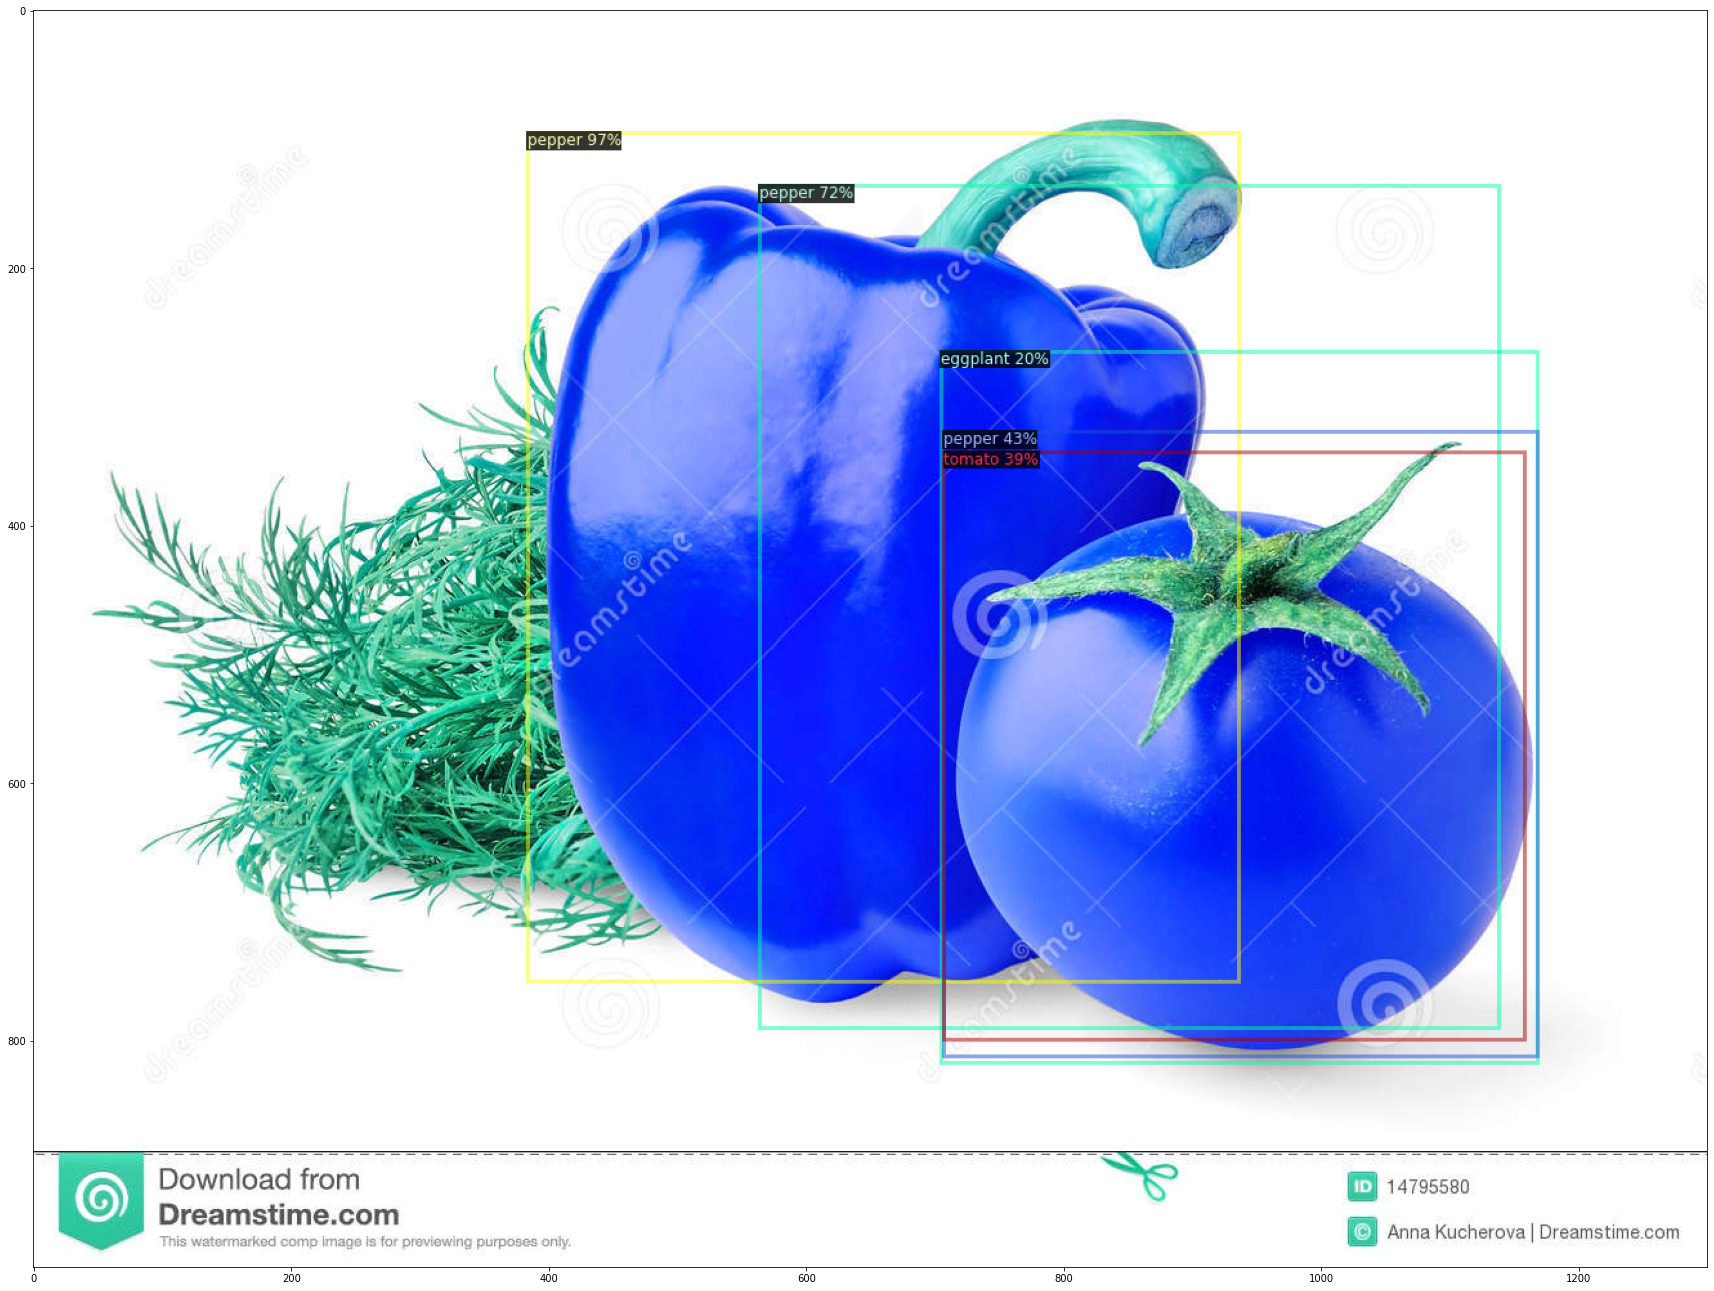

['pepper', 'pepper', 'pepper', 'tomato', 'eggplant']
[0.9749649167060852, 0.7160787582397461, 0.42717570066452026, 0.386111319065094, 0.2014237642288208]


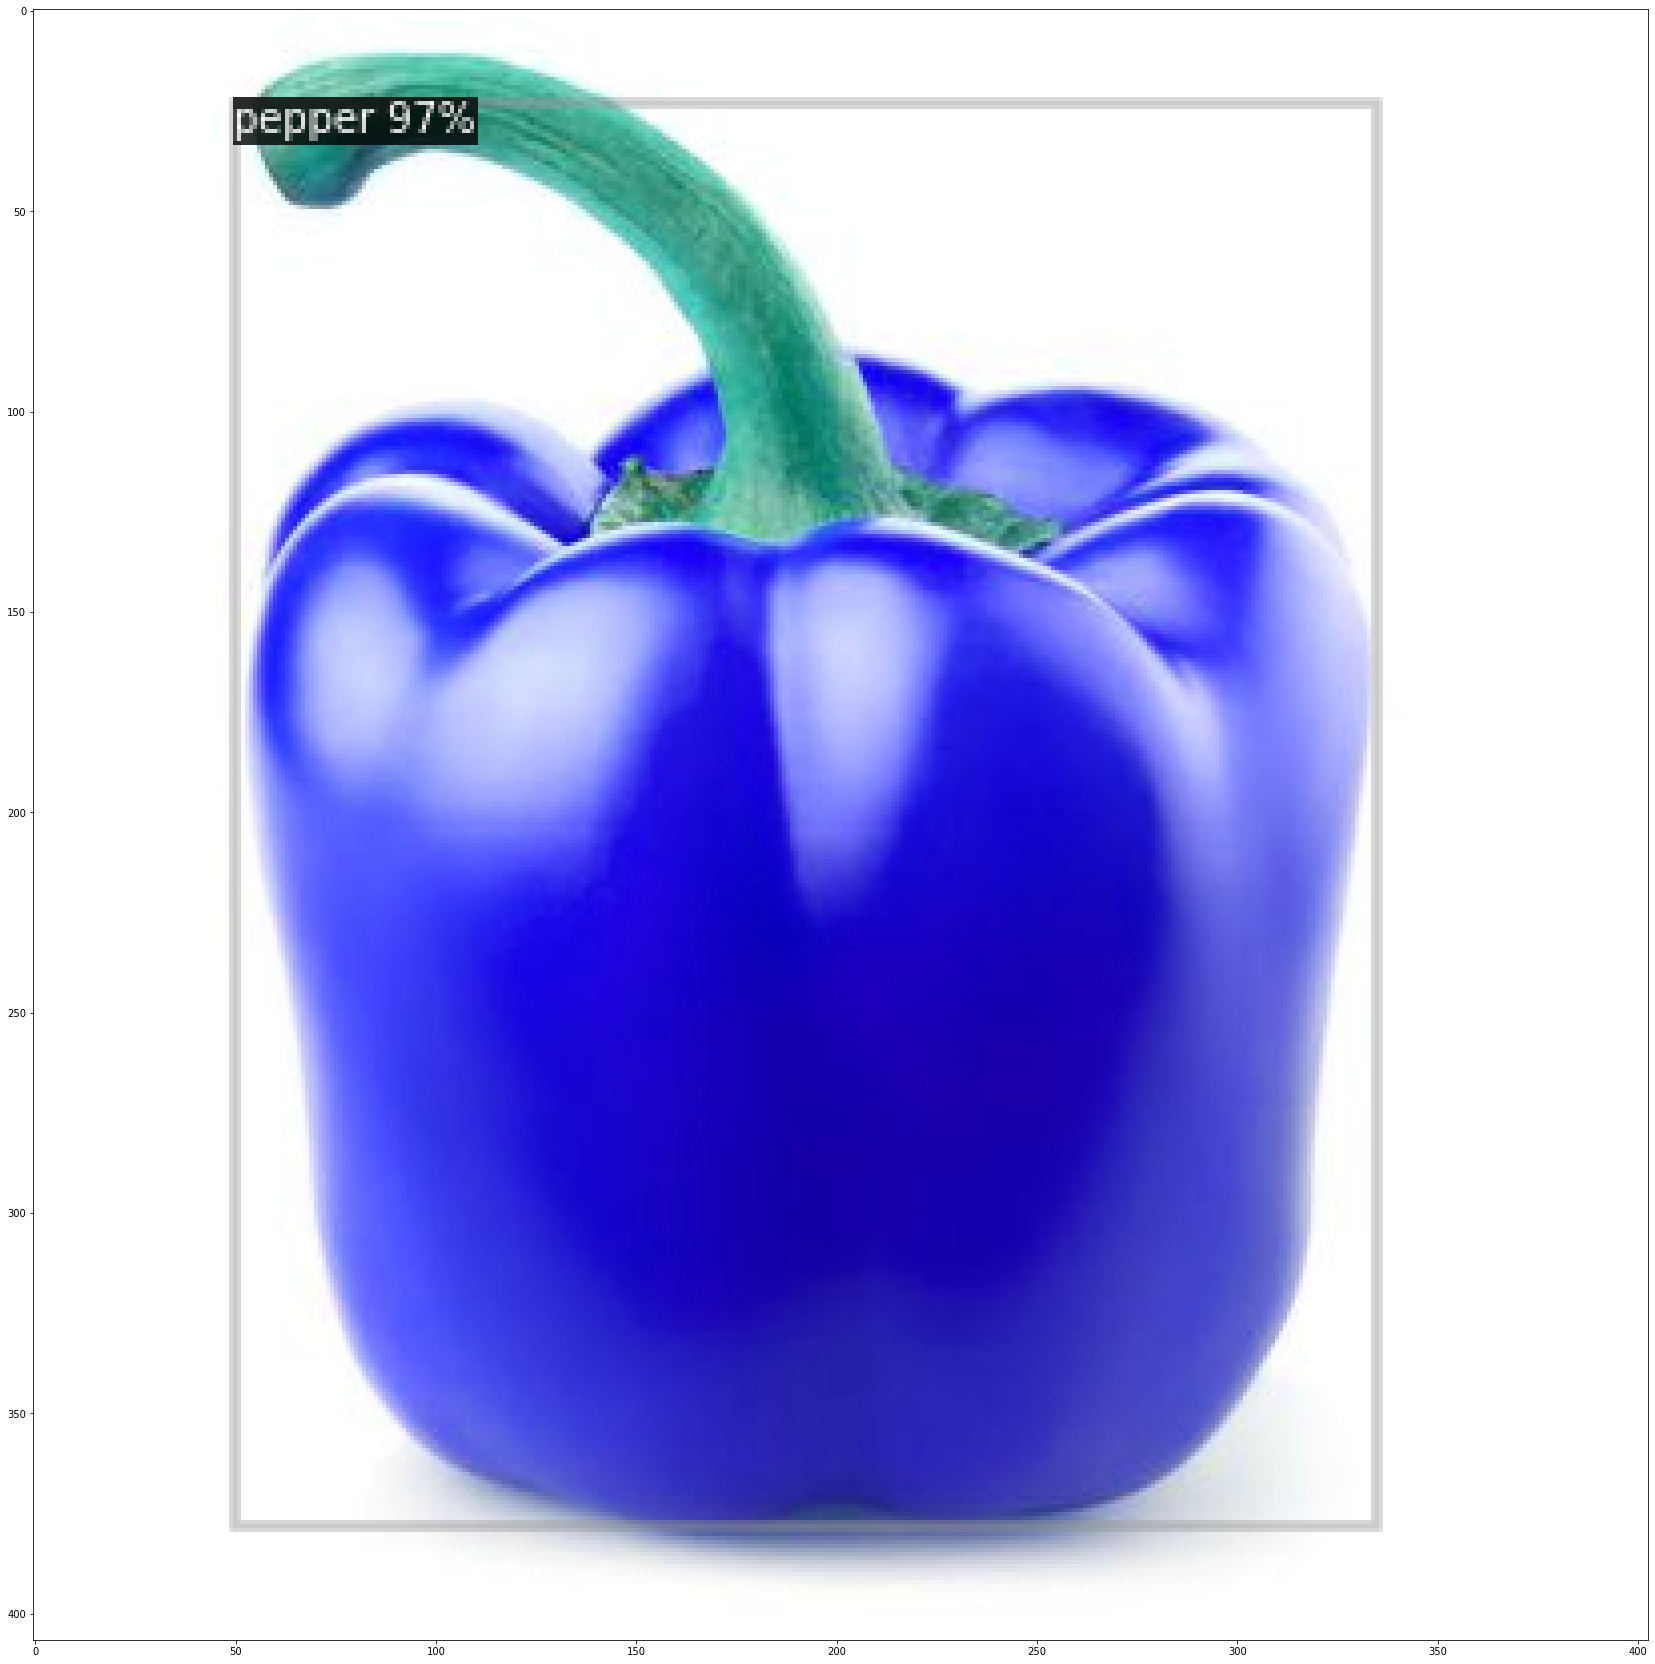

['pepper']
[0.9652080535888672]


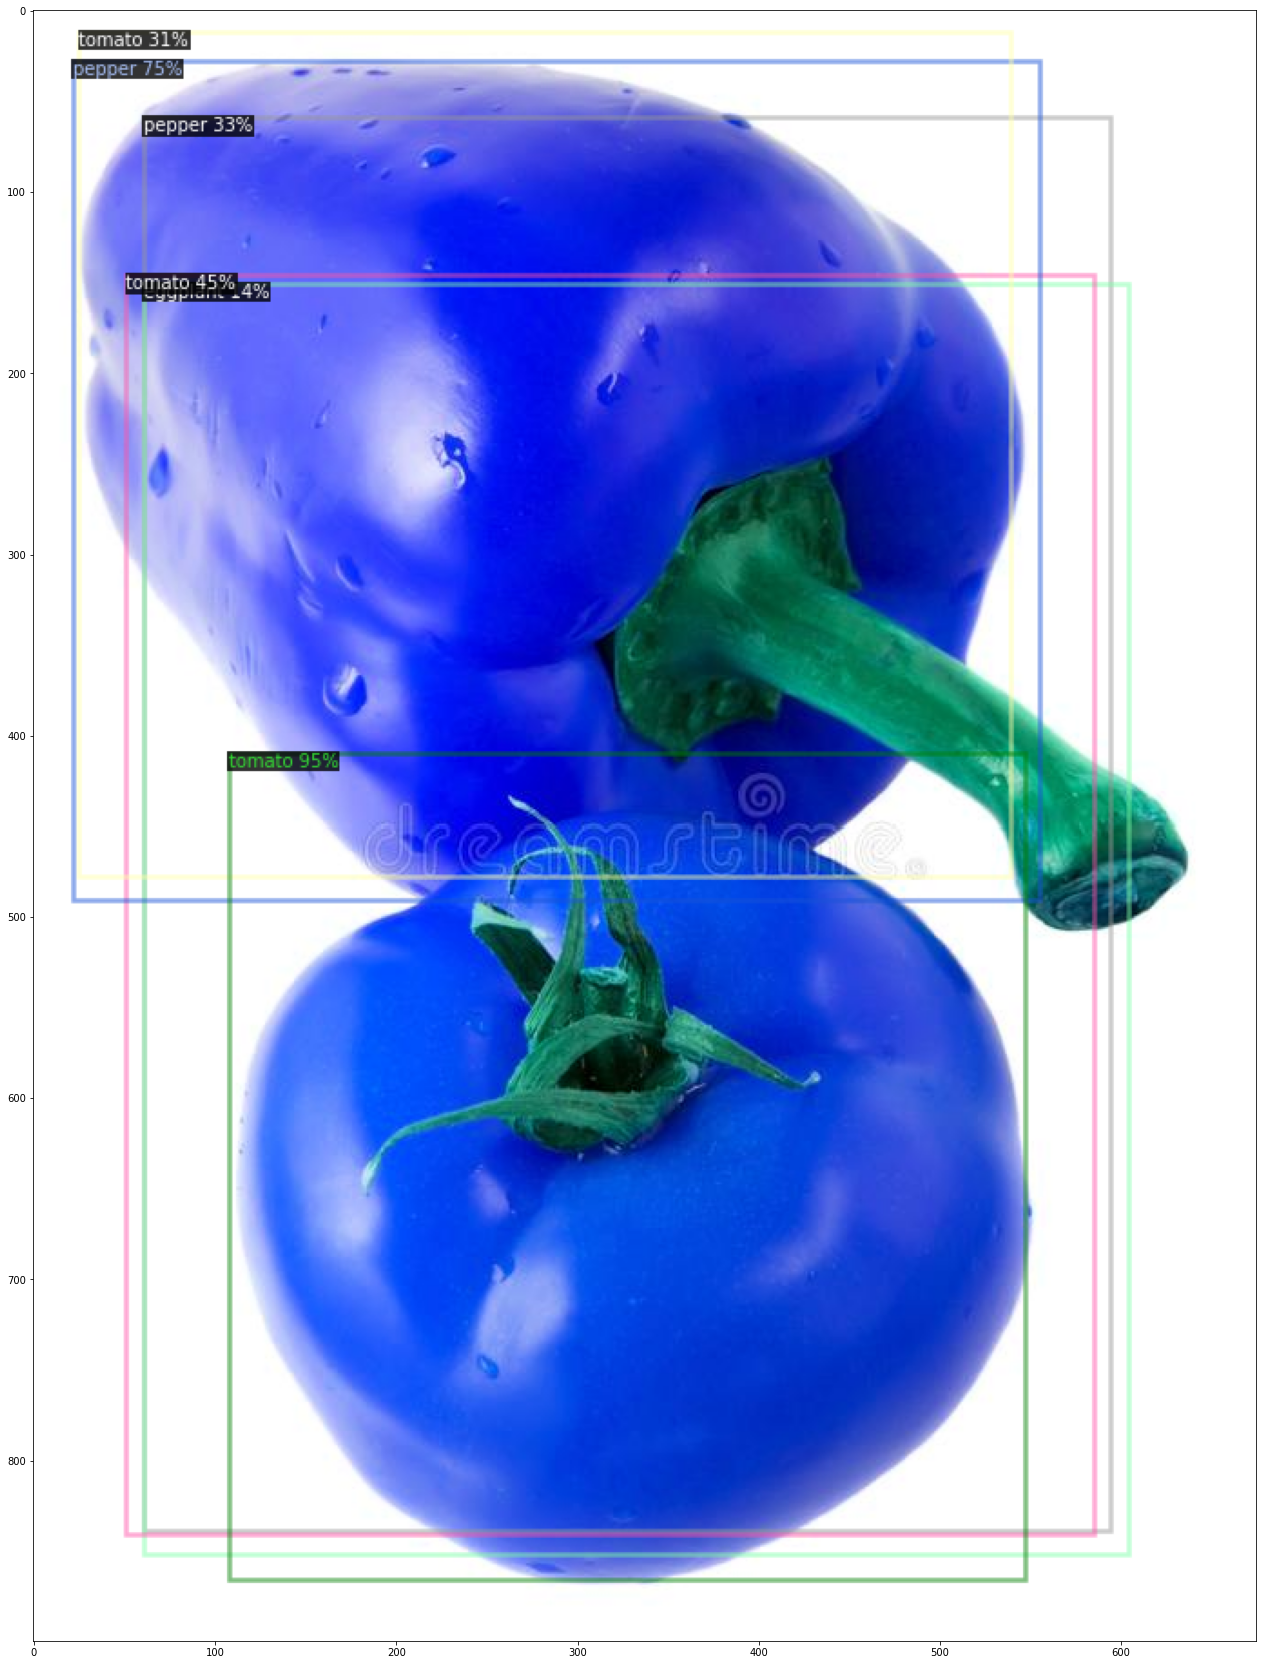

['tomato', 'pepper', 'tomato', 'pepper', 'tomato', 'eggplant']
[0.9545609354972839, 0.7514538168907166, 0.446501225233078, 0.3309028744697571, 0.30619701743125916, 0.1375783532857895]


In [53]:
predictor = DefaultPredictor(cfg)
for image in glob.glob('testimages/*'):
    im = cv2.imread(image)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=train_dataset_metadata)
    instances = outputs["instances"].to("cpu")
    out = v.draw_instance_predictions(instances)
    plt.figure(figsize = (30 ,30))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    pred_classes = instances.pred_classes.tolist()
    pred_scores = instances.scores.tolist()
    pred_class_names = [train_dataset_metadata.thing_classes[x] for x in pred_classes]
    print(pred_class_names)
    print(pred_scores)